# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

### Note
All methods are realized in my_optimization.py, this notebook is for experiments only

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

__(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

1) Gradient
$$\nabla_w Loss(w) = \nabla_w \frac1n \sum\limits_{i=1}^n \ln(1 + \exp(-w^Tx_i y_i)) = \frac1n \sum\limits_{i=1}^n \frac{-x_i y_i\exp(-w^Tx_i y_i)}{1 + \exp(-w^Tx_i y_i)}$$

2) $L = \| \frac14 X_n^TX_n \|$ as the reference from https://web.eecs.umich.edu/~fessler/course/598/l/n-03-gd.pdf page 53 

3) Convexity: yes, the logistic regression is a convex optimization problem, because Logloss is a convex function



In [2]:
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import my_optimization as opt

__(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

In [3]:
#1
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2*y - 3
args = {}
args['n'], args['d'] = X.shape

args['X_train'], args['X_test'], args['y_train'], args['y_test'] = train_test_split(X, y, test_size=0.25, random_state=True)

#2
args['L'] = np.linalg.norm(1/(4*args['n']) * args['X_train'].T @ args['X_train'])
print(args['L'])

2.013288493062904


In [4]:
def logloss(w, args):
    ans = 0
    for i in range(len(args['X_train'])):
        ans += np.log(1 + np.exp(-(w @ args["X_train"][i]) * args["y_train"][i]))
    return ans / len(args["X_train"])

def logloss_grad(w, args):
    grad = np.zeros(w.size)
    n_samples = args['X_train'].shape[0]
    for i in range(n_samples):
        grad += - args['X_train'][i] * args['y_train'][i] * np.exp(- w.dot(args['X_train'][i]) * args['y_train'][i]) / (1 + np.exp(- w.dot(args['X_train'][i]) * args['y_train'][i]))
    return grad / n_samples

def log_acc(k, f, grad_f, x_k, x_true, args):
    corr_count = 0
    test_count = len(args['y_test'])
    for i in range(test_count):
        if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
            corr_count += 1
    return corr_count / test_count

In [5]:
def gamma_k(k, f, grad_f, x_k, x_true, args):
        return 1/args['L']

In [6]:
bonuses_comp_crit_x, bonuses_comp_crit_y, bonuses_comp_crit_label = [], [], []

In [7]:
#3  
n_iter = 100 #with 1000 acc_hw3 = 0.995569, acc_hw2 = 0.996061, which is approximately the same
x_0 = np.zeros(args['d'])

gd = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                           args = args, n_iter = n_iter, gamma_k = gamma_k, acc_k = log_acc)

points_arr_gd, differences_arr_gd, times_arr_gd, acc_arr_gd = gd.descent()

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


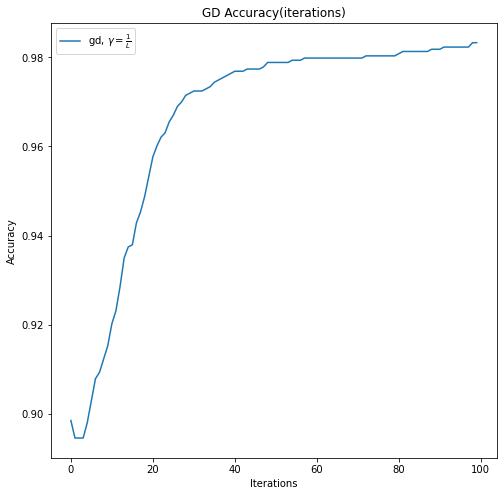

In [8]:
x_gd, y_gd, labels_gd = [], [], []
x_gd.append([i for i in range(n_iter)])
y_gd.append(acc_arr_gd)
labels_gd.append(r'gd, $\gamma = \frac{1}{L}$')

title_gd = 'GD Accuracy(iterations)'

opt.plot_graphs(x_gd, y_gd, x_label = "Iterations", lines_labels = labels_gd, title = title_gd, 
                logscale = False, criteria_type = "Accuracy")

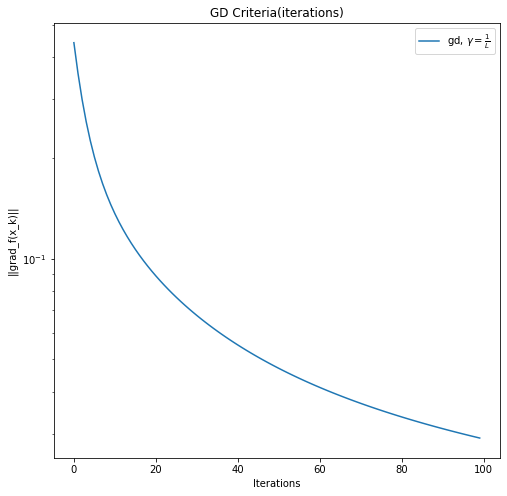

In [9]:
x_gd, y_gd, labels_gd = [], [], []
x_gd.append([i for i in range(n_iter)])
y_gd.append(differences_arr_gd)
labels_gd.append(r'gd, $\gamma = \frac{1}{L}$')

title_gd = 'GD Criteria(iterations)'

opt.plot_graphs(x_gd, y_gd, x_label = "Iterations", lines_labels = labels_gd, title = title_gd, 
                logscale = True, criteria_type = "||grad_f(x_k)||")

In [10]:
bonuses_comp_crit_x.append(x_gd[0])
bonuses_comp_crit_y.append(y_gd[0])
bonuses_comp_crit_label.append(labels_gd[0])

### 4
Here I don't need any regularization, because the accuracy for the number of iterations less than in HW2 is approximately the same. Only the gradient is calculated for long time enough due to calculations complexoty

In [11]:
#5
Accuracy_hw2 =  0.9960610536681438
Accuracy_hw3 = acc_arr_gd[-1]
print(r'acc_hw3 = %f, acc_hw2 = %f, which is approximately the same' %(Accuracy_hw3, Accuracy_hw2))

acc_hw3 = 0.983259, acc_hw2 = 0.996061, which is approximately the same


## Задача 2

__(a)__ Реализуйте метод тяжелого шарика. 

__(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

In [12]:
times_comp, acc_comp, labels_comp = [], [], []
times_comp.append(times_arr_gd)
acc_comp.append(acc_arr_gd)
labels_comp.append(labels_gd[0])

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


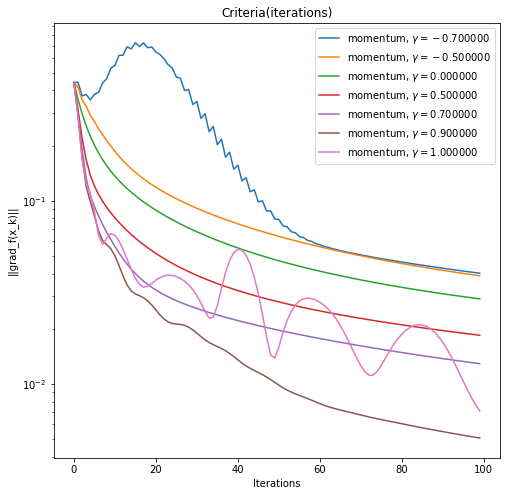

In [13]:
n_iter = 100
x_0 = np.zeros(args['d'])
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
momentum_coef_arr = [-0.7, -0.5, 0, 0.5, 0.7, 0.9, 1.]
def momentum_coeff(k, f, grad_f, x_k, x_true, args):
        return args['momentum_coeff']

for args['momentum_coeff'] in momentum_coef_arr:
        momentum_gd = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_k, momentum_gd_activate = True, 
                                acc_k = log_acc, momentum_coeff_k = momentum_coeff)

        points_arr, differences_arr, times_arr, acc_arr = momentum_gd.descent()

        x.append(n_iter_arr)
        y.append(differences_arr)
        labels.append(r'momentum, $\gamma = %f$' % args['momentum_coeff'])
        title = 'Criteria(iterations)'
        
        #for further comparison
        times_comp.append(times_arr)
        acc_comp.append(acc_arr)
        labels_comp.append(r'momentum, $\gamma = %f$' % args['momentum_coeff'])

opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = title, 
                        logscale = True, criteria_type = "||grad_f(x_k)||")

In [14]:
bonuses_comp_crit_x.append(x[5])
bonuses_comp_crit_y.append(y[5])
bonuses_comp_crit_label.append(labels[5])

As we can see the convergence is not always monotonous, ex. $\gamma = 1$

The best gamma is $\gamma = 0.9$

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

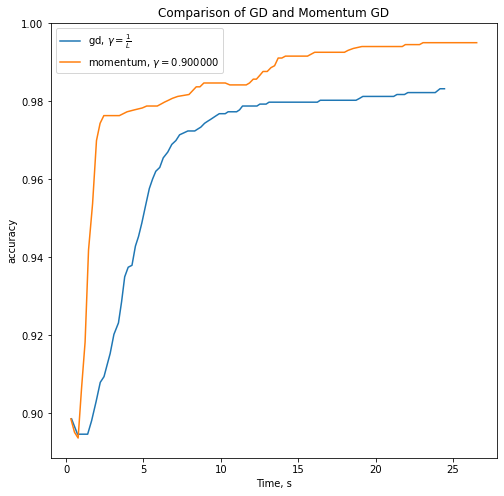

In [15]:
title = 'Comparison of GD and Momentum GD'
opt.plot_graphs(times_comp, acc_comp, x_label = "Time, s", lines_labels = labels_comp, title = title, 
                logscale = False, criteria_type = "accuracy" , specific_slice = [0, 6]) #0 and 6 are for gd ans best momentum

As we see the momentum algorithms requires less time to hit the higher accuracy value, because the momentum technique gives us the inertion

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

No problems occured

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

__(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

The $\mu$ costant is actually that small that the last fraction is equal to 1, and I consider this case

100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


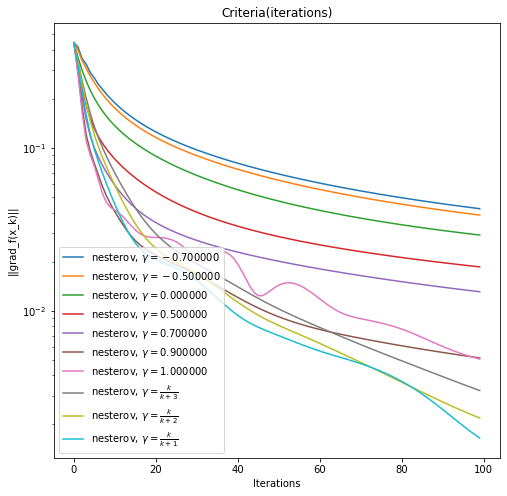

In [16]:
n_iter = 100
x_0 = np.zeros(args['d'])
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
const_momentum_coeff_arr = [-0.7, -0.5, 0, 0.5, 0.7, 0.9, 1.]
k_momentum_arr = [3, 2, 1]

def momentum_coeff_k(k, f, grad_f, x_k, x_true, args):
        return k/(k + args['i'])

def momentum_coeff_const(k, f, grad_f, x_k, x_true, args):
        return args['momentum_coeff']

for args['momentum_coeff'] in const_momentum_coeff_arr:    
    nesterov = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                            args = args, n_iter = n_iter, gamma_k = gamma_k, 
                            nesterov_momentum_activate = True, acc_k = log_acc, momentum_coeff_k = momentum_coeff_const)

    points_arr, differences_arr, times_arr, acc_arr = nesterov.descent()

    x.append(n_iter_arr)
    y.append(differences_arr)
    labels.append(r'nesterov, $\gamma = %f$' % args['momentum_coeff'])
    title = 'Criteria(iterations)'
    
    #for further comparison
    times_comp.append(times_arr)
    acc_comp.append(acc_arr)
    labels_comp.append(r'nesterov, $\gamma = %f$' % args['momentum_coeff'])

for args['i'] in k_momentum_arr:    
    nesterov = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                            args = args, n_iter = n_iter, gamma_k = gamma_k, 
                            nesterov_momentum_activate = True, acc_k = log_acc, momentum_coeff_k = momentum_coeff_k)

    points_arr, differences_arr, times_arr, acc_arr = nesterov.descent()

    x.append(n_iter_arr)
    y.append(differences_arr)
    labels.append(r'nesterov, $\gamma = \frac{k}{k + %i}$' % args['i'])
    title = 'Criteria(iterations)'
    
    #for further comparison
    times_comp.append(times_arr)
    acc_comp.append(acc_arr)
    labels_comp.append(r'nesterov, $\gamma = \frac{k}{k + %i}$' % args['i'])

opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = title, 
                        logscale = True, criteria_type = "||grad_f(x_k)||")

In [17]:
bonuses_comp_crit_x.append(x[9])
bonuses_comp_crit_y.append(y[9])
bonuses_comp_crit_label.append(labels[9])

As we see the fastest one is when $\gamma = \frac{k}{k + 1}$. The convergence is not always monotonous, as we can see from the plot

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

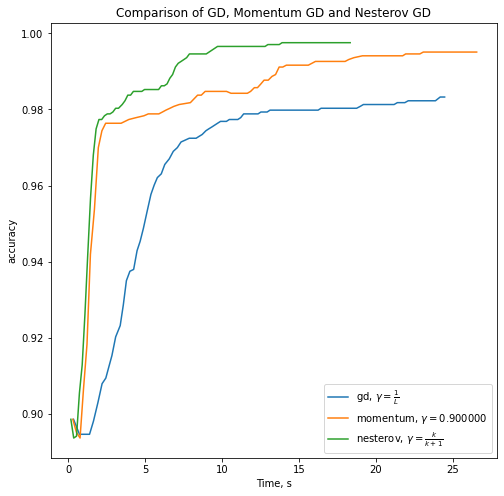

In [18]:
title = 'Comparison of GD, Momentum GD and Nesterov GD'
opt.plot_graphs(times_comp, acc_comp, x_label = "Time, s", lines_labels = labels_comp, title = title, 
                logscale = False, criteria_type = "accuracy", specific_slice = [0, 6, 17]) 
                #0, 6, 17  are for gd, best momentum, best nesterov

# Conclusion
The best method in terms of time required to achieve the certain value of accuracy is Nesterov momentum, basic momentum (heavy ball) is a bit worse in terms of the final accuracy, although it gains accuracy faster when n_iter is small, both accelerated algorithms better than basic gradient descent in terms of accuracy(time), because we consider the inertion in these algorithms.

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

From Lecture about the accelerated methods we know some facts:

$h$ should have the module of gradx and with the opposite sign because it is similar to the GD step 

Obviously, $\rho$ should be more than 1 because we need to increase the $L$ constant, but not that big to pass though the optimal one. From lecture we can say we can double it, so $\rho = 2$

$L_0$ should be small, to increase it if it didn't fit, we can choose $L_0 = \frac{L}{4}$

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [19]:
def backtracking_L(f, nabla_f, x, h, L0, rho):
    L = L0
    fx = f(x, args)
    gradx = nabla_f(x, args)
    while True:
        y = x - 1 / L * h
        if f(y, args) <= fx - 1 / L * gradx.dot(h)\
            + 1 / (2 * L) * h.dot(h):
            break
        else:
            L = L * rho
    return L

def gamma_k_backtracking(k, f, grad_f, x_k, x_true, args):
    h = - grad_f(x_k, args)
    L = backtracking_L(f, grad_f, x_k, h, args['L']/4, 2)
    return 1/L


In [20]:
n_iter = 100
x_0 = np.zeros(args['d'])
n_iter_arr = [i for i in range(n_iter)]

def momentum_coeff_k_best(k, f, grad_f, x_k, x_true, args):
        return k/(k + 1)

def momentum_coeff_const_best(k, f, grad_f, x_k, x_true, args):
        return 0.9

gd_backtracking = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                           args = args, n_iter = n_iter, gamma_k = gamma_k_backtracking, acc_k = log_acc)

points_arr, differences_arr, times_arr, acc_arr = gd_backtracking.descent()

bonuses_comp_crit_x.append(n_iter_arr)
bonuses_comp_crit_y.append(differences_arr)
bonuses_comp_crit_label.append(r'gd backtracking')

times_comp.append(times_arr)
acc_comp.append(acc_arr)
labels_comp.append(r'gd backtracking')

momentum_backtracking = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_k_backtracking, momentum_gd_activate = True, 
                                acc_k = log_acc, momentum_coeff_k = momentum_coeff_const_best)

points_arr, differences_arr, times_arr, acc_arr = momentum_backtracking.descent()

bonuses_comp_crit_x.append(n_iter_arr)
bonuses_comp_crit_y.append(differences_arr)
bonuses_comp_crit_label.append(r'momentum backtracking $\gamma = 0.9$')

times_comp.append(times_arr)
acc_comp.append(acc_arr)
labels_comp.append(r'momentum backtracking $\gamma = 0.9$')
   
nesterov_backtracking = opt.GradientOptimizer(logloss, logloss_grad, x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma_k_backtracking, 
                        nesterov_momentum_activate = True, acc_k = log_acc, momentum_coeff_k = momentum_coeff_k_best)

points_arr, differences_arr, times_arr, acc_arr = nesterov_backtracking.descent()

bonuses_comp_crit_x.append(n_iter_arr)
bonuses_comp_crit_y.append(differences_arr)
bonuses_comp_crit_label.append(r'nesterov backtracking $\gamma = \frac{k}{k + 1}$')

times_comp.append(times_arr)
acc_comp.append(acc_arr)
labels_comp.append(r'nesterov backtracking $\gamma = \frac{k}{k + 1}$')

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


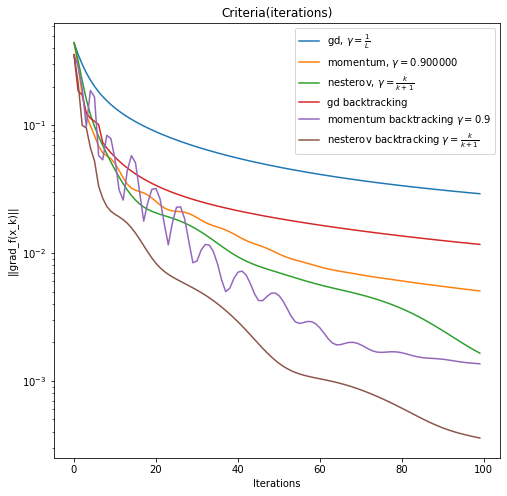

In [24]:
title = 'Criteria(iterations)'
opt.plot_graphs(bonuses_comp_crit_x, bonuses_comp_crit_y, x_label = "Iterations", lines_labels = bonuses_comp_crit_label, title = title, 
logscale = True, criteria_type = "||grad_f(x_k)||")

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

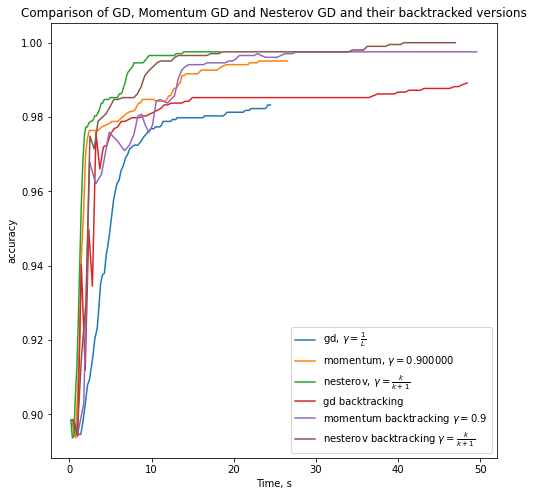

In [22]:
title = 'Comparison of GD, Momentum GD and Nesterov GD and their backtracked versions'
opt.plot_graphs(times_comp, acc_comp, x_label = "Time, s", lines_labels = labels_comp, title = title, 
                logscale = False, criteria_type = "accuracy", specific_slice = [0, 6, 17, 18, 19, 20])

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [23]:
#ответ